## Hyperparameter Tuning in SageMaker

In [3]:
!pip install -U pip torchvision sagemaker ipywidgets botocore s3transfer

In [2]:
import sagemaker
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)

sagemaker_session = sagemaker.Session()

bucket = sagemaker_session.default_bucket()
prefix = "sagemaker/DEMO-pytorch-cifar"

role = sagemaker.get_execution_role()

In [32]:
from torchvision.datasets import CIFAR10
from torchvision import transforms


local_dir = 'data'
CIFAR10.mirrors = ["https://sagemaker-sample-files.s3.amazonaws.com/datasets/image/CIFAR10/"]
cifar10_dataset = CIFAR10(
    local_dir,
    download=True,
    transform=transforms.Compose(
        [transforms.ToTensor()]
    )
)

classes = cifar10_dataset.classes
print(classes)

Files already downloaded and verified
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [5]:
# TODO: Upload the data to an S3 bucket. You can use the sagemaker_session object, boto3 or the AWS CLI
inputs = sagemaker_session.upload_data(path="data", bucket=bucket, key_prefix=prefix)

print("input spec (in this case, just an S3 path): {}".format(inputs))

input spec (in this case, just an S3 path): s3://sagemaker-us-east-1-145975612560/sagemaker/DEMO-pytorch-cifar


In [6]:
from sagemaker.pytorch import PyTorch

estimator = PyTorch(
    entry_point="cifar.py",
    role=role,
    py_version='py36',
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.m5.large"
)

In [7]:
#TODO: Initialise your hyperparameters
hyperparameter_ranges = {
    "lr": ContinuousParameter(0.001, 0.1),
    "batch-size": CategoricalParameter([32, 64, 128, 256, 512]),
    "epochs": IntegerParameter(2, 4)
}

In [8]:
objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Test set: Average loss: ([0-9\\.]+)"}]

In [9]:
#TODO: Create your HyperparameterTuner Object
tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=4,
    max_parallel_jobs=2,
    objective_type=objective_type,
)

In [10]:
#TODO: Train your model
tuner.fit({"training": inputs})

.............................................................................!


In [11]:
predictor = tuner.deploy(initial_instance_count=1, instance_type="ml.t2.medium")


2023-02-14 22:16:54 Starting - Found matching resource for reuse
2023-02-14 22:16:54 Downloading - Downloading input data
2023-02-14 22:16:54 Training - Training image download completed. Training in progress.
2023-02-14 22:16:54 Uploading - Uploading generated training model
2023-02-14 22:16:54 Completed - Resource retained for reuse
---------!

## Query the Endpoint

In [86]:
import numpy as np
import torch

file = 'data/cifar-10-batches-py/data_batch_1'
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

data=unpickle(file)
random_img = random.choice(data[b'data'])
image = np.reshape(random_img, (3, 32, 32)).astype(np.uint8)
image_tensor = torch.tensor(image, dtype=torch.float32)
image_tensor = image_tensor.unsqueeze(0) # Add a batch dimension
print(image_tensor)

tensor([[[[246., 251., 251.,  ..., 250., 255., 255.],
          [248., 252., 249.,  ..., 249., 254., 255.],
          [250., 249., 250.,  ..., 248., 252., 251.],
          ...,
          [249., 253., 253.,  ..., 249., 250., 251.],
          [245., 249., 252.,  ..., 250., 249., 251.],
          [247., 246., 247.,  ..., 253., 251., 251.]],

         [[249., 252., 250.,  ..., 253., 247., 245.],
          [251., 253., 248.,  ..., 253., 250., 252.],
          [253., 250., 249.,  ..., 253., 248., 249.],
          ...,
          [252., 253., 251.,  ..., 249., 250., 252.],
          [251., 253., 253.,  ..., 250., 249., 251.],
          [255., 252., 250.,  ..., 253., 251., 251.]],

         [[252., 254., 252.,  ..., 255., 254., 252.],
          [253., 254., 250.,  ..., 254., 254., 254.],
          [254., 252., 253.,  ..., 253., 250., 250.],
          ...,
          [249., 251., 250.,  ..., 249., 250., 252.],
          [247., 250., 251.,  ..., 250., 249., 251.],
          [250., 248., 247.,  ...

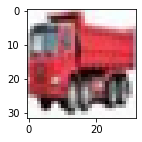

In [87]:
import matplotlib.pyplot as plt

# Convert tensor to numpy array
image_array = image_tensor.squeeze().numpy()

# Rescale the pixel values to [0, 1]
image_array = image_array / 255.0

# Display the image
plt.figure(figsize = (20,2))
plt.imshow(np.transpose(image_array, (1, 2, 0)))
plt.show()


In [88]:
# TODO: Query the endpoint
response = predictor.predict(image_tensor)
print(response)

[[ -938.34338379  -558.04003906 -1896.21496582 -1384.16015625
  -2217.21801758 -1525.21948242 -2425.56835938 -1000.24951172
  -1538.17956543     0.        ]]


In [89]:
inference_class = int(np.argmax(response, 1)[0])
print(f"Inferred class:\nClass name: {cifar10_dataset.classes[inference_class]}, Index: {inference_class} ")

Inferred class:
Class name: truck, Index: 9 


### Cleanup

After you have finished with this exercise, remember to delete the prediction endpoint to release the instance associated with it

In [90]:
predictor.delete_endpoint()